Notebook is out of date. Previously, we compared all attack strategies here. Now we have too many and their names differ across protocols.

In [1]:
# %load withholding.py
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

df = pd.read_csv("../../data/withholding.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except:
        return np.array([float("nan")])


def split_network(s):
    if s.startswith("two-agents"):
        return ("two-agents", 0)
    elif s.startswith("gamma"):
        return ("gamma", float(s.split("-")[1]))
    else:
        raise ValueError("unknown network")


def expand(row):
    compute = parse_array(row.compute)
    rcompute = compute / np.sum(compute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / row.number_activations
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    d = {}
    d["attacker_compute"] = rcompute[0]
    d["attacker_relative_activations"] = ractivations[0]
    d["attacker_relative_reward"] = rreward[0]
    d["attacker_gain"] = rreward[0] - ractivations[0]
    d["attacker_efficiency"] = rreward[0] / ractivations[0]
    d["network_type"], d["gamma"] = split_network(row["network"])
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

In [2]:
df.columns

Index(['network', 'network_description', 'compute', 'protocol', 'k',
       'protocol_description', 'block_interval', 'activation_delay',
       'number_activations', 'activations', 'incentive_scheme',
       'incentive_scheme_description', 'strategy', 'strategy_description',
       'reward', 'ca_time', 'ca_height', 'machine_duration_s', 'error',
       'version', 'attacker_compute', 'attacker_relative_activations',
       'attacker_relative_reward', 'attacker_gain', 'attacker_efficiency',
       'network_type', 'gamma'],
      dtype='object')

# Nakamoto

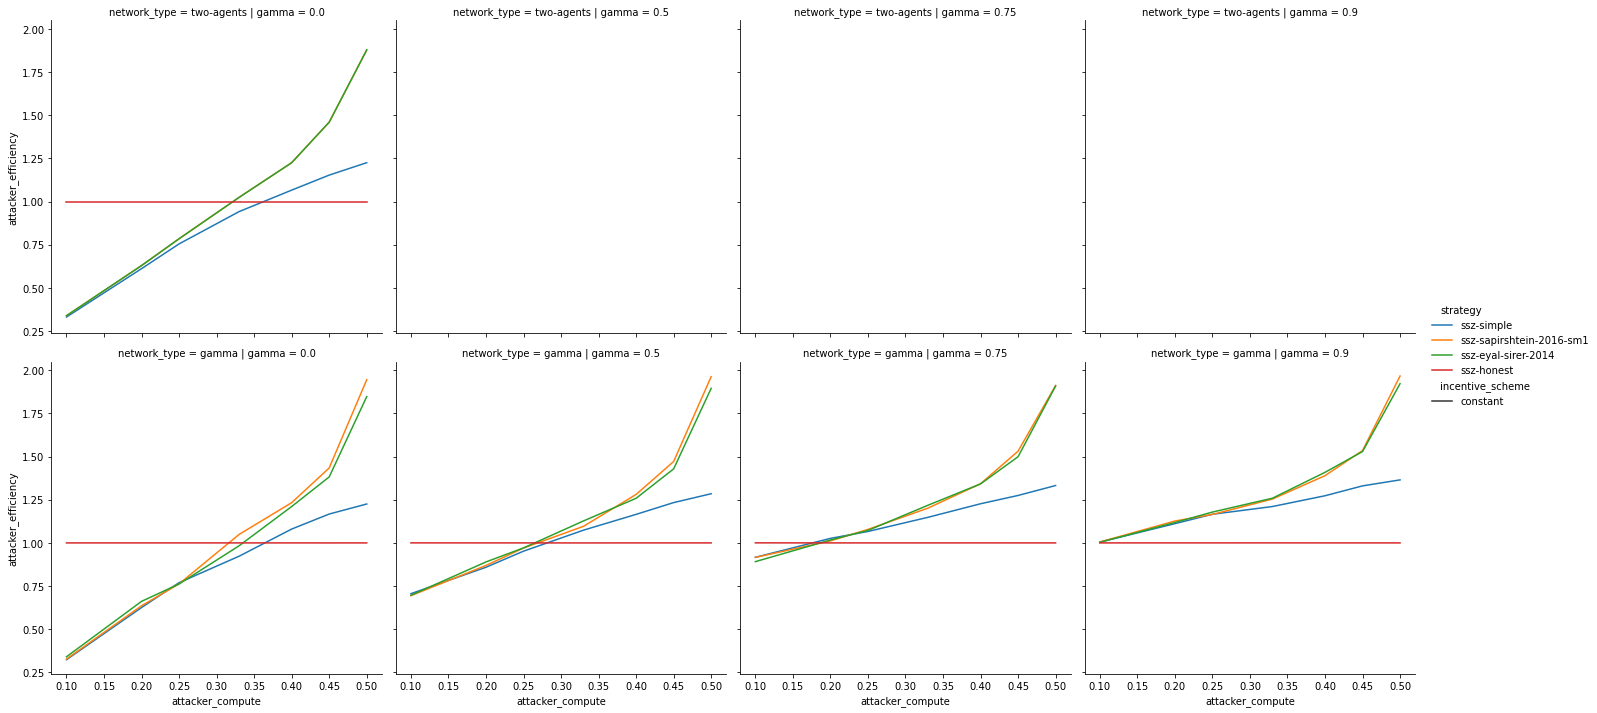

In [3]:
sns.relplot(
    data=df[df.protocol == "nakamoto"],
    kind="line",
    x="attacker_compute",
    y="attacker_efficiency",
    row="network_type",
    col="gamma",
    hue="strategy",
    style="incentive_scheme",
)

# Ethereum

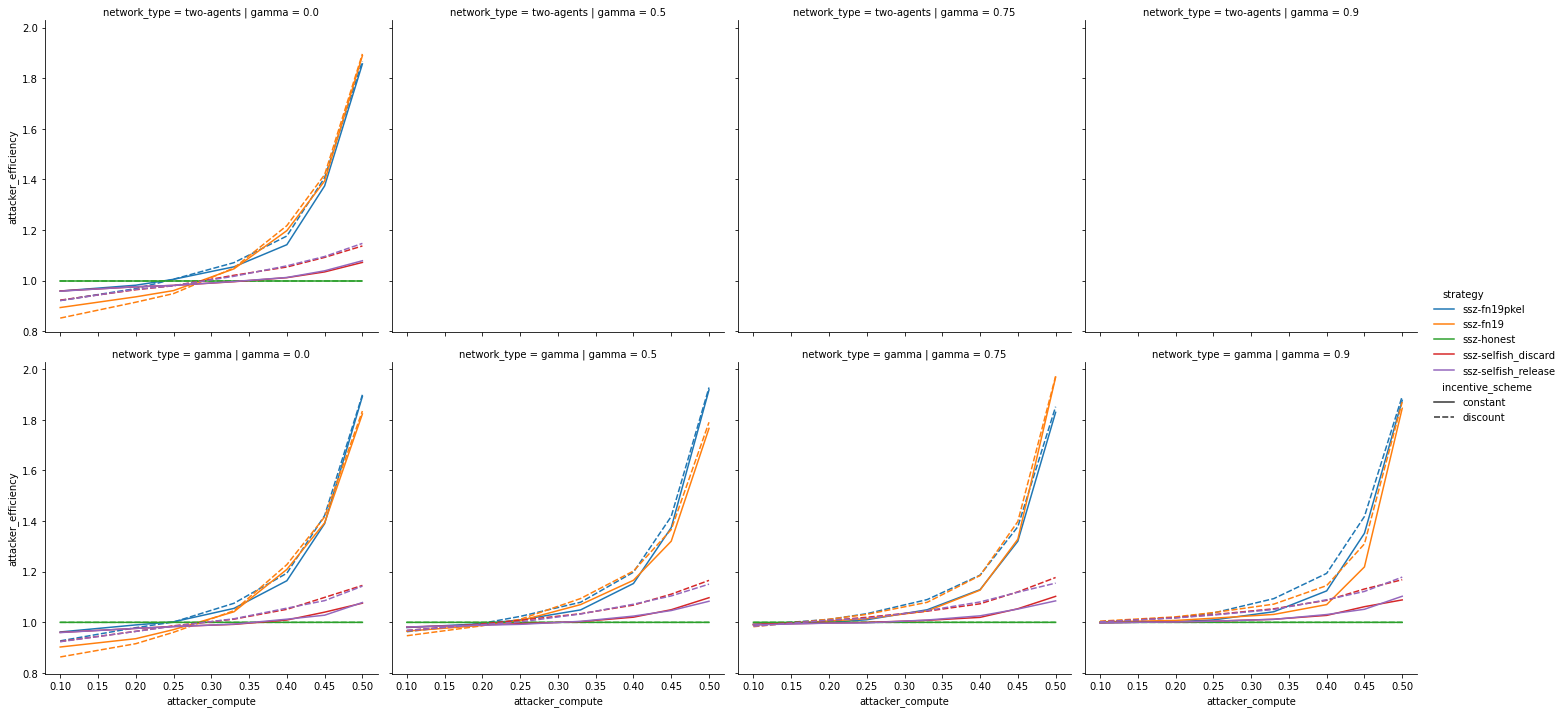

In [4]:
sns.relplot(
    data=df[df.protocol == "ethereum"],
    kind="line",
    x="attacker_compute",
    y="attacker_efficiency",
    row="network_type",
    col="gamma",
    hue="strategy",
    style="incentive_scheme",
)

# Nakamto vs some other protocols

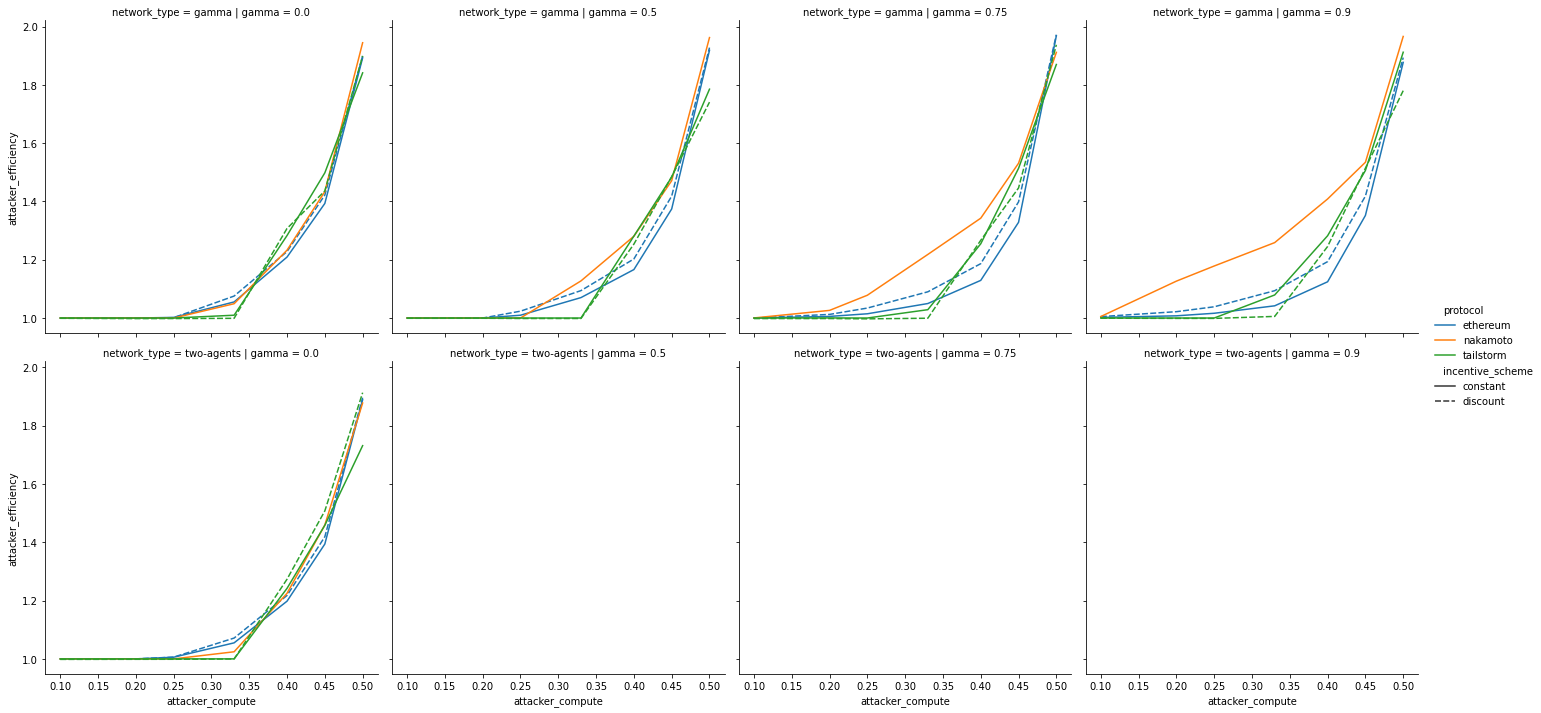

In [5]:
dd = df.query(
    "protocol == 'nakamoto' or protocol == 'ethereum' or (protocol == 'tailstorm' and k == 8)"
)
dd = dd.query("incentive_scheme in ['constant', 'discount']")
dd = dd[[x.startswith("ssz-") for x in dd.strategy]]
key = ["protocol", "attacker_compute", "network_type", "gamma", "incentive_scheme"]
dd = dd[key + ["attacker_efficiency"]].groupby(key).max()
sns.relplot(
    data=dd,
    kind="line",
    x="attacker_compute",
    y="attacker_efficiency",
    row="network_type",
    col="gamma",
    hue="protocol",
    style="incentive_scheme",
)